# <center>Flow++ [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_moons import *
from utils.training_mnist import *
from utils.training_dataloader_2d import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Flow++:**

**Variational Dequantization:**


**Logistic Mixture Coupling:**
\begin{equation*}
    \begin{cases}
        z_{1:d} = x_{1:d} \\
        z_{d+1:D} = \sigma^{-1}(\mathrm{MixLogCDF}(x_{d+1:D};\pi_\theta(x_{1:d}),\mu_\theta(x_{1:d}),s_\theta(x_{1:d})))\odot \exp(a_\theta(x_{1:d}))+b_\theta(x_{1:d})
    \end{cases}
\end{equation*}
where:
\begin{equation*}
    \mathrm{MixLogCDF}(x;\pi,\mu,s)=\sum_{k=1}^K \pi_i \sigma((x-\mu_i)\odot\exp(-s_i))
\end{equation*}
\begin{equation*}
    \sigma(x)=\frac{1}{1+e^{-x}} \text{ (sigmoid)}
\end{equation*}
with $\pi$, $\mu$, $s$, $a$ and $b$ neural nets.

The jacobian of $\mathrm{MixLogCDF}$ is the pdf:
\begin{align*}
    \mathrm{MixLogPDF}(x;\pi,\mu,s) = \sum_{k=1}^K \pi_i \exp(-s_i) \sigma'((x-\mu_i)\exp(-s_i))
\end{align*}

And:
\begin{equation*}
    \sigma'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}}\frac{e^{-x}}{1+e^{-x}} = \sigma(x)(1-\sigma(x))
\end{equation*}

Moreover,
\begin{equation*}
    \sigma^{-1}(y) = \mathrm{logit}(y)=\log\Big(\frac{y}{1-y}\Big)
\end{equation*}
and
\begin{equation*}
    (\sigma^{-1})'(y) = \frac{1}{y}+\frac{1}{1-y}=\frac{1}{y(1-y)}
\end{equation*}

Thus, the log determinant of the jacobian is:
\begin{equation*}
    \log\det J = a(x_{1:d})+\log((\sigma^{-1})'(\mathrm{MixLogCDF(x)}))+\mathrm{MixLogPDF}(x)
\end{equation*}

$\mathrm{MixLogCDF}$ can be inverted by bisection (by solving $\mathrm{MixLogCDF}(x)=y$).

In [3]:
## Stolen from https://github.com/didriknielsen/survae_flows/tree/271a31d11cf00fad83270a9f699ff68a03da44ab

def logistic_log_cdf(x, means, log_scales):
    return F.logsigmoid(torch.exp(-log_scales) * (x - means))


def logistic_log_one_minus_cdf(x, means, log_scales):
    '''
    Uses that:
    `log(1-sigmoid(x)) = - softplus(x)`
    '''
    return -F.softplus(torch.exp(-log_scales) * (x - means))


def logistic_log_pdf(x, means, log_scales):
    '''
    Uses that:
    pdf(x) = dcdf(x)/dx
           = dsigmoid((x-m)/s)/dx
           = 1/s * sigmoid((x-m)/s) * (1-sigmoid((x-m)/s))
    '''
    return - log_scales + logistic_log_cdf(x, means, log_scales) + logistic_log_one_minus_cdf(x, means, log_scales)


def bisection_inverse(fn, z, init_x, init_lower, init_upper, eps=1e-10, max_iters=100):
    '''Bisection method to find the inverse of `fn`. Computed by finding the root of `z-fn(x)=0`.'''

    def body(x_, lb_, ub_, cur_z_):
        gt = (cur_z_ > z).type(z.dtype)
        lt = 1 - gt
        new_x_ = gt * (x_ + lb_) / 2. + lt * (x_ + ub_) / 2.
        new_lb = gt * lb_ + lt * x_
        new_ub = gt * x_ + lt * ub_
        return new_x_, new_lb, new_ub

    x, lb, ub = init_x, init_lower, init_upper
    cur_z = fn(x)
    diff = float('inf')
    i = 0
    while diff > eps and i < max_iters:
        x, lb, ub = body(x, lb, ub, cur_z)
        cur_z = fn(x)
        diff = (z - cur_z).abs().max()
        i += 1

    return x

In [4]:
class MLP(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers, K):
        super().__init__()

        self.K = K

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))

        self.dense_a = nn.Linear(nh,d_out)
        self.dense_b = nn.Linear(nh,d_out)
        self.dense_pi = nn.Linear(nh,d_out*K)
        self.dense_mu = nn.Linear(nh,d_out*K)
        self.dense_s = nn.Linear(nh,d_out*K)


    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)

        a = self.dense_a(x)
        b = self.dense_b(x)
        pi = self.dense_pi(x)
        mu = self.dense_mu(x)
        s = self.dense_s(x)

        return a, b, pi, mu, s


class LogisticMixture(BaseNormalizingFlow):
    def __init__(self, dim, mlp):
        super().__init__()
        self.d = dim
        self.k = dim//2
        self.nn = mlp

    def forward(self, x):
        x0, x1 = x[:,:self.k], x[:,self.k:]
        a, b, pi, mu, s = self.nn(x0)
        
        pi = pi.reshape(x.size(0),self.k,-1)
        mu = mu.reshape(x.size(0),self.k,-1)
        s = s.reshape(x.size(0),self.k,-1)

        log_cdf = logistic_log_cdf(x1.unsqueeze(-1), mu, s)
        y1 = torch.logsumexp(torch.log_softmax(pi,dim=-1) + log_cdf, dim=-1).exp()

        log_pdf = logistic_log_pdf(x1.unsqueeze(-1), mu, s)
        log_det_mixture = torch.logsumexp(torch.log_softmax(pi,dim=-1)+log_pdf, dim=-1)

        z1 = torch.logit(y1,eps=1e-7)*torch.exp(a)+b
        log_det_logit = -torch.log(torch.clamp(y1,min=1e-7))-torch.log(torch.clamp(1-y1,min=1e-7))

        z = torch.cat([x0,z1], dim=1)
        log_det = a+log_det_logit+log_det_mixture

        return z, log_det[:,0]

    def backward(self, z, eps=1e-10, max_iters=100):
        z0, z1 = z[:,:self.k], z[:,self.k:]

        a, b, pi, mu, s = self.nn(z0)

        pi = pi.reshape(z.size(0),self.k,-1)
        mu = mu.reshape(z.size(0),self.k,-1)
        s = s.reshape(z.size(0),self.k,-1)

        def mix_cdf(x):
            log_cdf = logistic_log_cdf(x.unsqueeze(-1), mu, s)
            return torch.logsumexp(torch.log_softmax(pi,dim=-1) + log_cdf, dim=-1).exp()

        y1 = torch.sigmoid(torch.exp(-a)*(z1-b))

        max_scales = torch.sum(torch.exp(s), dim=-1, keepdim=True)
        init_lower, _ = (mu - 20 * max_scales).min(dim=-1)
        init_upper, _ = (mu + 20 * max_scales).max(dim=-1)

        x1 = bisection_inverse(fn=lambda x: mix_cdf(x), 
                               z=y1,
                               init_x=torch.zeros_like(y1),
                               init_lower=init_lower,
                               init_upper=init_upper,
                               eps=eps,
                               max_iters=max_iters)

        x = torch.cat([z0,x1], dim=1)

        return x       

        

## Moons

In [6]:
d = 2
K=5

mlps = [MLP(d//2,64,d//2,3,K) for k in range(5)]

flows = []
for i in range(4):
    flows.append(LogisticMixture(d, mlps[i]))
    flows.append(Reverse(d))
    # flows.append(ActNorm(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  54852


0 2.559098958969116


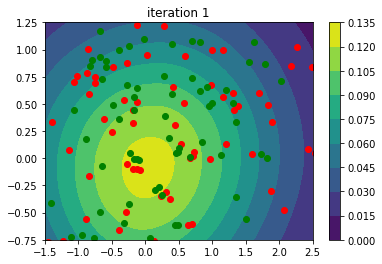

1000 1.3736205101013184


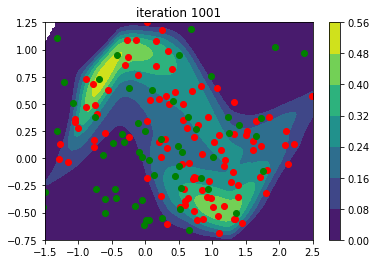

2000 1.2143371105194092


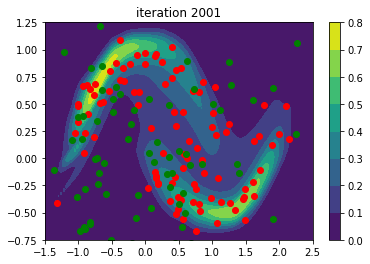

3000 1.1064436435699463


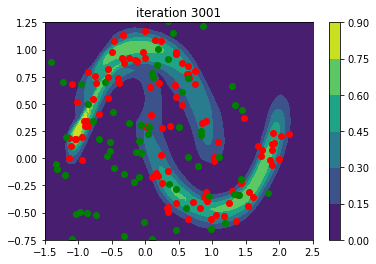

4000 1.1296507120132446


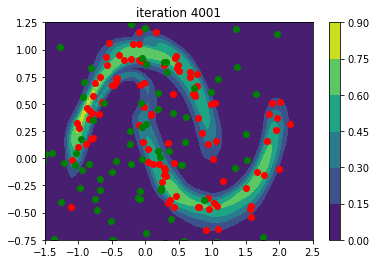

5000 1.042935848236084


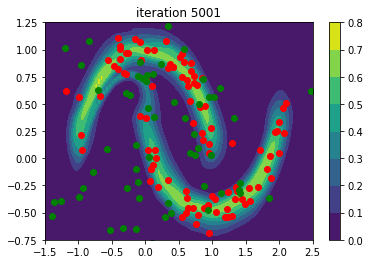

6000 1.0394129753112793


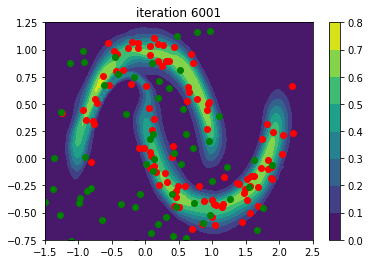

7000 1.0494506359100342


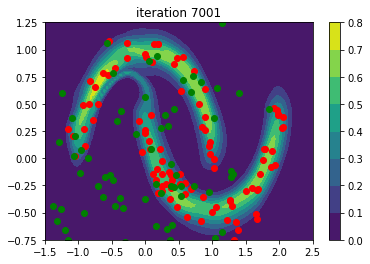

8000 1.065612554550171


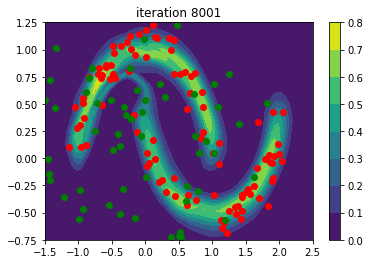

9000 1.0904734134674072


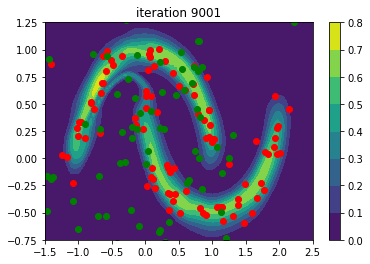

10000 1.0897464752197266


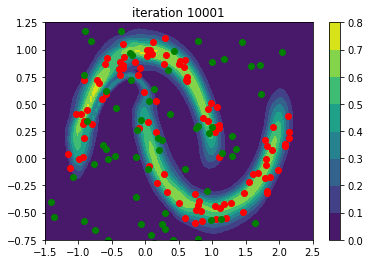

In [7]:
train_loss = train_moons(model, optimizer, n_epochs=10001)

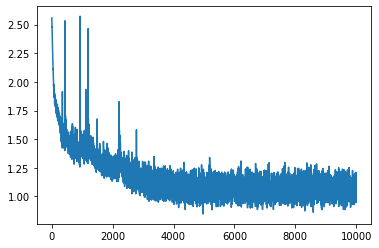

In [8]:
plt.plot(train_loss)
plt.show()

## 8 Gaussians

In [5]:
def create_gaussians(num_points):
    """
        Adapted from https://github.com/rtqichen/ffjord/blob/master/lib/toy_data.py
    """
    scale = 4.
    bias = np.pi / 8
    step = np.pi / 4
    centers = [(np.cos(bias + 0*step), np.sin(bias + 0*step)),
               (np.cos(bias + 1*step), np.sin(bias + 1*step)),
               (np.cos(bias + 2*step), np.sin(bias + 2*step)),
               (np.cos(bias + 3*step), np.sin(bias + 3*step)),
               (np.cos(bias + 4*step), np.sin(bias + 4*step)),
               (np.cos(bias + 5*step), np.sin(bias + 5*step)),
               (np.cos(bias + 6*step), np.sin(bias + 6*step)),
               (np.cos(bias + 7*step), np.sin(bias + 7*step))]
    centers = [(scale * x, scale * y) for x, y in centers]

    dataset = []
    for i in range(num_points):
        point = np.random.randn(2) * 0.5
        idx = np.random.randint(8)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset /= 1.414
    return torch.from_numpy(dataset)

In [6]:
X = create_gaussians(1000)

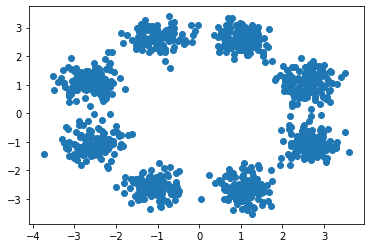

In [7]:
Xnp = X.numpy()
plt.scatter(Xnp[:,0],Xnp[:,1])
plt.show()

In [8]:
train_set = create_gaussians(128000)
test_set = create_gaussians(128000)

In [9]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

### Flow++

In [10]:
d = 2
K=5

mlps = [MLP(d//2,64,d//2,3,K) for k in range(5)]

flows = []
for i in range(4):
    flows.append(LogisticMixture(d, mlps[i]))
    flows.append(Reverse(d))
    # flows.append(ActNorm(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  54852


0 3.3601582789421083


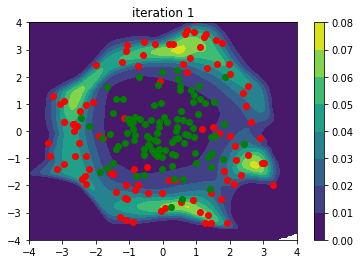

5 3.0427159719467163


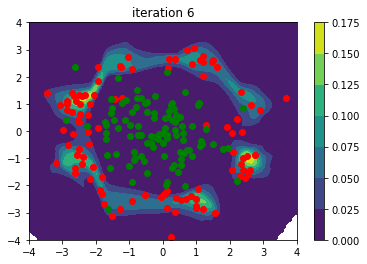

10 2.9799944393634794


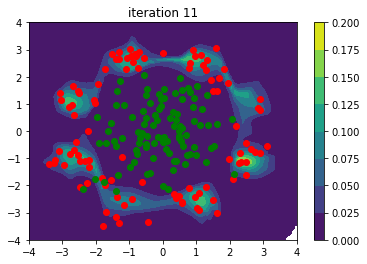

In [11]:
train_loss = train_dataloader(model,optimizer,train_loader,test_loader,n_epochs=11)

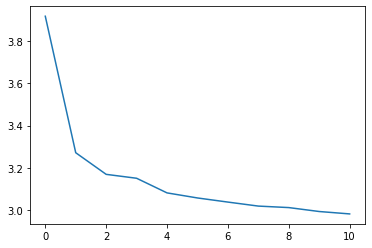

In [12]:
plt.plot(train_loss)
plt.show()

## References

<a id="reference1"></a>

[1] Ho, J., Chen, X., Srinivas, A., Duan, Y., & Abbeel, P. Flow++: Improving Flow-Based Generative Models with Variational Dequantization and Architecture Design. arXiv preprint arXiv:1902.00275. (2019). [link](https://arxiv.org/abs/1902.00275)